<a href="https://colab.research.google.com/github/Yacin-e/TP-AI/blob/main/tp04_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**TP 05** Opérateurs connexes et segmentation


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

First we must manually upload the zip file to colab

In [4]:
!unzip ImageProcessingLab-main.zip


Archive:  ImageProcessingLab-main.zip
67e3a9a0519985afe08d9522464b9bd5f17f917a
   creating: ImageProcessingLab-main/
  inflating: ImageProcessingLab-main/.gitignore  
  inflating: ImageProcessingLab-main/LICENSE  
  inflating: ImageProcessingLab-main/Makefile  
  inflating: ImageProcessingLab-main/README.md  
  inflating: ImageProcessingLab-main/azure-pipelines.yml  
   creating: ImageProcessingLab-main/bin/
 extracting: ImageProcessingLab-main/bin/binary.png  
  inflating: ImageProcessingLab-main/bin/blobs-bad.png  
  inflating: ImageProcessingLab-main/bin/blobs.png  
 extracting: ImageProcessingLab-main/bin/blood.png  
 extracting: ImageProcessingLab-main/bin/camera.png  
 extracting: ImageProcessingLab-main/bin/camera_bruit_gaussien.png  
  inflating: ImageProcessingLab-main/bin/camera_bruit_poivre_et_sel.png  
 extracting: ImageProcessingLab-main/bin/camera_mauvaise_balance.png  
  inflating: ImageProcessingLab-main/bin/cas1.png  
  inflating: ImageProcessingLab-main/bin/cas11.png 

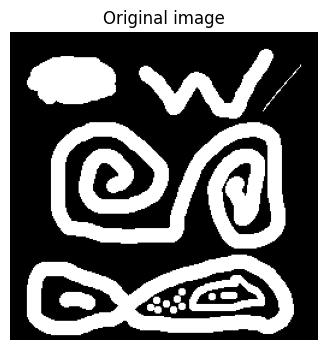

In [10]:
binary = cv2.imread("/content/ImageProcessingLab-main/bin/binary.png", cv2.IMREAD_GRAYSCALE)
binary = binary.astype(np.float32)

def show(img, title="", cmap="gray"):
    plt.figure(figsize=(4,4))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis("off")
    plt.show()

show(binary, "Original image")


Ex 1

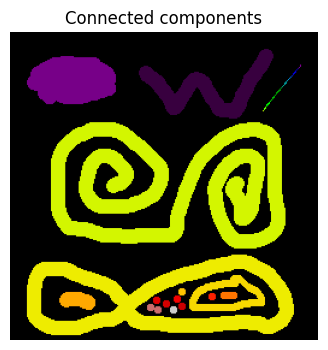

In [11]:
def connected_components_4(binary):
    h, w = binary.shape
    labels = np.zeros((h, w), dtype=np.int32)
    current_label = 1

    for y in range(h):
        for x in range(w):
            if binary[y, x] != 0 and labels[y, x] == 0:
                queue = deque()
                queue.append((y, x))
                labels[y, x] = current_label

                while queue:
                    cy, cx = queue.popleft()
                    for dy, dx in [(-1,0), (1,0), (0,-1), (0,1)]:
                        ny, nx = cy + dy, cx + dx
                        if (0 <= ny < h and 0 <= nx < w and
                            binary[ny, nx] != 0 and labels[ny, nx] == 0):
                            labels[ny, nx] = current_label
                            queue.append((ny, nx))

                current_label += 1

    return labels

labels = connected_components_4(binary)

show(labels, "Connected components", cmap="nipy_spectral")



Ex 2

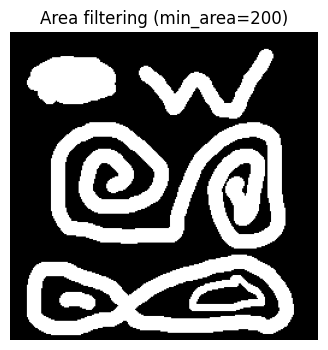

In [12]:
def area_filter(binary, min_area):
    labels = connected_components_4(binary)
    result = np.zeros_like(binary)

    for label in np.unique(labels):
        if label == 0:
            continue
        area = np.sum(labels == label)
        if area >= min_area:
            result[labels == label] = 1

    return result

filtered = area_filter(binary, min_area=200)

show(filtered, "Area filtering (min_area=200)")


Ex 3

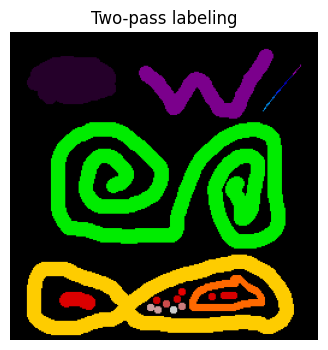

In [13]:
def two_pass_labeling(binary):
    h, w = binary.shape
    labels = np.zeros((h, w), dtype=int)
    parent = {}
    next_label = 1

    def find(x):
        while parent[x] != x:
            x = parent[x]
        return x

    def union(a, b):
        ra, rb = find(a), find(b)
        if ra != rb:
            parent[rb] = ra

    # First pass
    for y in range(h):
        for x in range(w):
            if binary[y, x] == 0:
                continue

            neighbors = []
            if x > 0 and labels[y, x-1] > 0:
                neighbors.append(labels[y, x-1])
            if y > 0 and labels[y-1, x] > 0:
                neighbors.append(labels[y-1, x])

            if not neighbors:
                labels[y, x] = next_label
                parent[next_label] = next_label
                next_label += 1
            else:
                m = min(neighbors)
                labels[y, x] = m
                for n in neighbors:
                    union(m, n)

    for y in range(h):
        for x in range(w):
            if labels[y, x] > 0:
                labels[y, x] = find(labels[y, x])

    return labels

labels2 = two_pass_labeling(binary)

show(labels2, "Two-pass labeling", cmap="nipy_spectral")



Ex 4

In [14]:
def otsu_threshold(image):
    hist, _ = np.histogram(image.flatten(), bins=256, range=(0,256))
    total = image.size

    sum_total = np.dot(np.arange(256), hist)
    sum_bg = 0
    weight_bg = 0
    max_var = 0
    threshold = 0

    for t in range(256):
        weight_bg += hist[t]
        if weight_bg == 0:
            continue

        weight_fg = total - weight_bg
        if weight_fg == 0:
            break

        sum_bg += t * hist[t]
        mean_bg = sum_bg / weight_bg
        mean_fg = (sum_total - sum_bg) / weight_fg

        var_between = weight_bg * weight_fg * (mean_bg - mean_fg) ** 2

        if var_between > max_var:
            max_var = var_between
            threshold = t

    return threshold


def otsu_segmentation(image):
    t = otsu_threshold(image)
    return (image > t).astype(np.uint8)


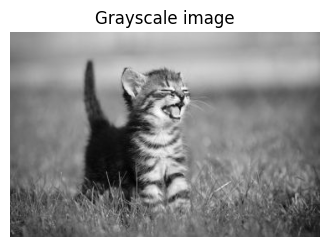

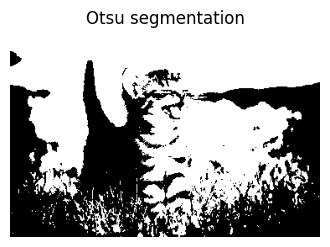

In [33]:
cat = cv2.imread("/content/ImageProcessingLab-main/bin/cat.jpg", cv2.IMREAD_GRAYSCALE)

show(cat, "Grayscale image")

seg = otsu_segmentation(cat)
show(seg, "Otsu segmentation")


Ex 5

In [25]:
def region_growing(image, seed, threshold):
    h, w = image.shape
    result = np.zeros((h, w), dtype=np.uint8)
    visited = np.zeros((h, w), dtype=bool)

    sy, sx = seed
    region_mean = float(image[sy, sx])
    region_pixels = [(sy, sx)]
    result[sy, sx] = 1
    visited[sy, sx] = True

    queue = deque([(sy, sx)])

    while queue:
        y, x = queue.popleft()
        for dy, dx in [(-1,0), (1,0), (0,-1), (0,1)]:
            ny, nx = y + dy, x + dx
            if (0 <= ny < h and 0 <= nx < w and not visited[ny, nx]):
                if abs(float(image[ny, nx]) - region_mean) <= threshold:
                    result[ny, nx] = 1
                    region_pixels.append((ny, nx))
                    region_mean = np.mean([image[p] for p in region_pixels])
                    queue.append((ny, nx))
                visited[ny, nx] = True

    return result


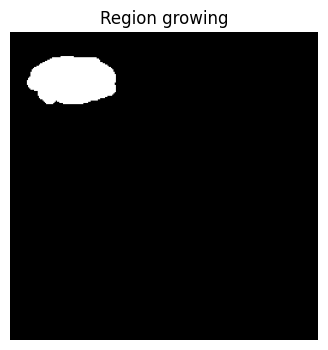

In [45]:
img2 = binary.astype(np.uint8)

seed = (50, 25)  # left region
region = region_growing(img2, seed, threshold=10)

show(region, "Region growing")


Ex 6

In [34]:
def split_region(image, y, x, size, threshold, result):
    region = image[y:y+size, x:x+size]
    if region.size == 0:
        return

    if np.var(region) < threshold or size == 1:
        result[y:y+size, x:x+size] = np.mean(region)
    else:
        half = size // 2
        split_region(image, y, x, half, threshold, result)
        split_region(image, y, x+half, half, threshold, result)
        split_region(image, y+half, x, half, threshold, result)
        split_region(image, y+half, x+half, half, threshold, result)


def split_and_merge(image, threshold):
    h, w = image.shape
    size = min(h, w)
    result = np.zeros_like(image, dtype=float)
    split_region(image, 0, 0, size, threshold, result)
    return result


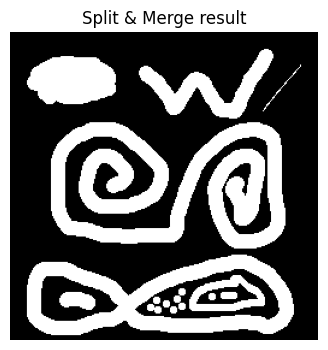

In [38]:
split = split_and_merge(binary, threshold=100)

show(split, "Split & Merge result")


**TP 6** Morphologie Mathématique

Ex 1

In [47]:
def se_cross():
    return np.array([[0,1,0],
                     [1,1,1],
                     [0,1,0]], dtype=np.uint8)

def se_square(size=3):
    return np.ones((size, size), dtype=np.uint8)

def se_horizontal(length=3):
    se = np.zeros((1, length), dtype=np.uint8)
    se[0, :] = 1
    return se

def se_vertical(length=3):
    se = np.zeros((length, 1), dtype=np.uint8)
    se[:, 0] = 1
    return se


In [48]:
def dilate(image, se):
    h, w = image.shape
    sh, sw = se.shape
    cy, cx = sh // 2, sw // 2

    result = np.zeros_like(image)

    for y in range(h):
        for x in range(w):
            max_val = 0
            for j in range(sh):
                for i in range(sw):
                    if se[j, i] == 1:
                        yy = y + j - cy
                        xx = x + i - cx
                        if 0 <= yy < h and 0 <= xx < w:
                            max_val = max(max_val, image[yy, xx])
            result[y, x] = max_val

    return result


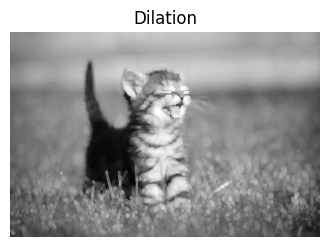

In [49]:
se = se_square(3)
dil = dilate(cat, se)

show(dil, "Dilation")


Ex 2

In [52]:
def erode(image, se):
    h, w = image.shape
    sh, sw = se.shape
    cy, cx = sh // 2, sw // 2

    result = np.zeros_like(image)

    for y in range(h):
        for x in range(w):
            min_val = 255
            for j in range(sh):
                for i in range(sw):
                    if se[j, i] == 1:
                        yy = y + j - cy
                        xx = x + i - cx
                        if 0 <= yy < h and 0 <= xx < w:
                            min_val = min(min_val, image[yy, xx])
                        else:
                            min_val = 0
            result[y, x] = min_val

    return result


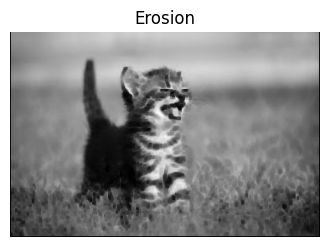

In [56]:
ero = erode(cat, se)

show(ero, "Erosion")

Ex 3

In [59]:
def close(image, se):
    return erode(dilate(image, se), se)

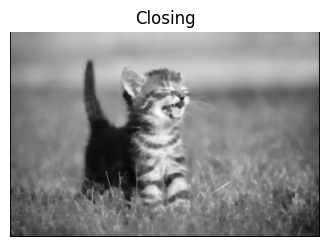

In [58]:
closed = close(cat, se)

show(closed, "Closing")

Ex 4

In [60]:
def open(image, se):
    return dilate(erode(image, se), se)


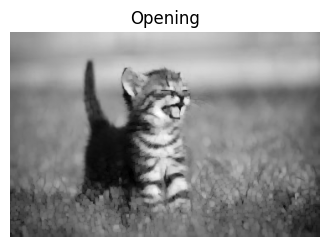

In [62]:
opened = open(cat, se)

show(opened, "Opening")

Ex 5

In [63]:
def morphological_gradient(image, se):
    dil = dilate(image, se)
    ero = erode(image, se)
    return dil - ero


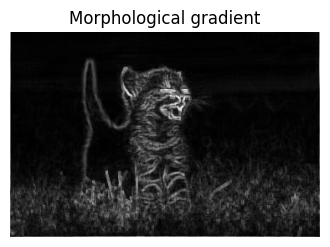

In [65]:
grad = morphological_gradient(cat, se)

show(grad, "Morphological gradient")